1 этап работы. 6 курс   
В этом файле содержится предобработка данных и сравнение распределений в экспериментальных и модельных даннных.  
Условие однородности необходимо проверить для того, чтобы мы могли утверждать, что выбранный алгоритм кластеризации на модельных данных подходит для кластеризации экспериментальных данных.  

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
mpl.use('TkAgg')
import math
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import warnings 
#warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
# ГРАФИКА
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
sns.set(style="whitegrid")
# Version
print(mpl.__version__)  #> 3.0.0
print(sns.__version__) 

3.3.2
0.11.0


### Считывание файлов с данными.  

In [3]:
# Необработанный банк экспериментальных данных для проверки
# Обработанный лежит в файле datachanged/AllExpC
data1 = pd.read_csv('data/AllExp.csv')
AllExp = data1.loc[data1[' num_of_fam']<=910].copy()
AllExp = AllExp[AllExp['E(J)']<999]
ColExp = AllExp.columns

In [5]:
# Обработанный новый банк данных (обработка в файле номер 4)
AllMc0 = pd.read_csv('datachanged/AllMc0CNewBank', sep = '\t')

In [6]:
# Вычисляем расстояние до энергитического центра
def Create_Distance(X, Y):
    R = (X*X+Y*Y)**0.5
    return R

In [7]:
#Добавляем расстояние в ДатаФрейм
AllExp['R'] = Create_Distance(AllExp['X(J)'].values, AllExp['Y(J)'].values)
AllExp = AllExp[AllExp['R']<15].copy()

In [8]:
# Удаление семейств, где количество частиц меньше или равно 3
def Amount(df, name):
    # Group values for Series and add 'cnt' column with count
    df['cnt'] = df.groupby([name])[name].transform('count')
    # Drop indexes for count value == 1, and dropping 'cnt' column
    df = df.drop(df[df.cnt<=2].index)
    return df

In [14]:
AllExp = Amount(AllExp, ' num_of_fam').copy()

In [15]:
AllExp['ER']=AllExp['E(J)']*AllExp['R']

1. Проверка данных на нормальность распределений.

In [25]:
def Normal_function(dataS, Some, label):
    alpha = 0.05 
    stat, p = stats.normaltest(dataS)
    print('Shapiro Statistics = %.3f, p = %e' % (stat, p))
    if p > alpha:
        print('Является нормальным (принять H0)')
    else:
        print('Не является нормальным (отклонить H0)')
        
    print()

#     sns.distplot(dataS, kde = 0, axlabel= f'values {Some} in {label} ')
#     plt.savefig(f'images/norm/norm_{Some}_{label}.png')

In [26]:
Normal_function(AllExp['X(J)'], 'X(J)', 'exp')

Shapiro Statistics = 2351.828, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [27]:
Normal_function(AllExp['Y(J)'], 'Y(J)', 'exp')

Shapiro Statistics = 2549.027, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [28]:
Normal_function(AllExp['R'], 'R', 'exp')

Shapiro Statistics = 7195.885, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [29]:
Normal_function(AllExp['E(J)'], 'E(J)', 'exp')

Shapiro Statistics = 30873.674, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [32]:
Normal_function(AllMc0['R'], 'R', 'mc0')

Shapiro Statistics = 53278.063, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [33]:
Normal_function(AllMc0['E(J)'], 'E(J)', 'mc0')

Shapiro Statistics = 365655.340, p = 0.000000e+00
Не является нормальным (отклонить H0)



2. Проверка на логнормальность.

In [34]:
# Распределение по всем энергиям в эксперименте не является логнормальным
ln_E = np.log(AllExp['E(J)'])
Normal_function(ln_E, 'ln_E', len(ln_E))

Shapiro Statistics = 4575.169, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [35]:
# Распределение по всем энергиям в эксперименте не является логнормальным
ln_E = np.log(AllMc0['E(J)'])
Normal_function(ln_E, 'ln_E', len(ln_E))

Shapiro Statistics = 42741.021, p = 0.000000e+00
Не является нормальным (отклонить H0)



3. Подсчет суммарных энергий в датасете по семействам.

In [39]:
# Функция считает сумму энергий для всех частиц на пленке 
# Печатает номер семейства, в котором суммарная энергия меньше 100, такие мы не рассматриваем
def Mean_of_Some(data, Some, name):
    
    Sum_of_E = []
    Sum_of_E_New = []
    
    Num = set(data[name])

    
    
    for i in Num: 
        OneFamily = pd.DataFrame( data.loc[lambda data: data[name] == i, :] ).copy()
        s = OneFamily[Some].sum()
        
        for j in range(len(OneFamily)):
            Sum_of_E_New.append( s ) 
        if s < 100:
            print(i)
        
        Sum_of_E.append( OneFamily[Some].sum() )
        #Mean_of_E.append( OneFamily[Some].mean() )
    
    
    return Sum_of_E, Sum_of_E_New

In [40]:
# Посчитаем распределения по суммам энергий и расстояний для эксперимента и модели
Sum_EE,  Sum_of_EE_New  = Mean_of_Some(AllExp, 'E(J)', ' num_of_fam')

40
100
104
322
343
494
554


In [42]:
Sum_EM,  Sum_of_EM_New = Mean_of_Some(AllMc0, 'E(J)', 'num')

In [44]:
AllExp['sum_energy'] = Sum_of_EE_New
AllExp = AllExp[AllExp['sum_energy']>100].copy()

In [47]:
AllExp['lg_r'] = np.log10(AllExp['R'].values)
AllExp['lg_e_r'] = np.log10(AllExp['ER'].values)

In [49]:
# Сохранение обработанных файлов в папку datachanged
# AllExp.to_csv('datachanged/AllExpC')

4. Проверка нормальности и логнормальности распределений по суммам энергий 

In [3]:
AllExp = pd.read_csv('datachanged/AllExpC')
AllMc0 = pd.read_csv('datachanged/AllMc0CNewBank', sep = '\t')

In [50]:
# Распределение по суммам энергий для эксперимента не является нормальным
Normal_function( Sum_EE, 'Sum_EE', len(Sum_EE))

Shapiro Statistics = 1158.151, p = 3.241800e-252
Не является нормальным (отклонить H0)



In [56]:
# Распределение по суммам энергий для эксперимента не является логнормальным
Normal_function( np.log(Sum_EE), 'Sum_EE', len(Sum_EE))

Shapiro Statistics = 219.465, p = 2.206440e-48
Не является нормальным (отклонить H0)



In [55]:
# Распределение по суммам средних расстояний для эксперимента не является нормальным
Normal_function(Sum_EM, 'Sum_EM', len(Sum_EM))

Shapiro Statistics = 3700.382, p = 0.000000e+00
Не является нормальным (отклонить H0)



In [57]:
# Распределение по суммам средних расстояний для эксперимента не является логнормальным
Normal_function( np.log(Sum_EM), 'Sum_EM', len(Sum_EM))

Shapiro Statistics = 498.929, p = 4.558783e-109
Не является нормальным (отклонить H0)



3. Посмотрим корреляцию между признаками отдельно в эксперименте и в модели.

In [58]:
def CorrelationBetween(dataS1, dataS2, Some1, Some2):
    alpha = 0.05
    N = len(dataS1)
    stat, p = stats.spearmanr(dataS1[:N], dataS2[:N])
    print('Spearmanr correlation = %.3f, p = %.3f' % (stat, p))
    
    if p > alpha:
        print('Нет корреляции')
    else:
        print('Есть корреляция')
        if stat < 0:
            print (f'С увеличением {Some1} уменьшается {Some2}')
        else:
            print (f'С увеличением {Some1} увеличивается {Some2}')

In [59]:
# Исследование зависимости между распределением расстояния R и энергией пятна.
# p < 0.05 => есть корреляция между R и E
# С увеличением R уменьшается E, так как отрицательная корреляция
CorrelationBetween(AllExp['R'], AllExp['E(J)'],'R', 'E')

Spearmanr correlation = -0.258, p = 0.000
Есть корреляция
С увеличением R уменьшается E


In [60]:
# Исследование зависимости между распределением расстояния R и энергией пятна.
# p < 0.05 => есть корреляция между R и E
# С увеличением R уменьшается E, так как отрицательная корреляция
CorrelationBetween(AllMc0['R'], AllMc0['E(J)'],'R', 'E')

Spearmanr correlation = -0.157, p = 0.000
Есть корреляция
С увеличением R уменьшается E


5. Теперь нужно проверить однородность данных в Эксперименте и в модели.  

In [63]:
AllExp = pd.read_csv('datachanged/AllExpC')
AllMc0 = pd.read_csv('datachanged/AllMc0CNewBank', sep = '\t')

In [65]:
# Построение нормированных графиков
def TwoGraphics_Norm( dataS1, dataS2, L, R, title, w):
    
       
    bins = np.linspace(L, R, 50)
    
    box_1 = {'facecolor':'white',    #  цвет области
       'edgecolor': 'red',     #  цвет крайней линии
       'boxstyle': 'round'}
    
    box_str = f'{title}_mean: exp = {round(np.mean(dataS1), 2)} mc0 = {round(np.mean(dataS2), 2)} '
    
    fig, ax = plt.subplots()
    
    plt.rcParams['font.size'] = '16'
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
    
    
    bins = np.linspace(L, R, 30)
    plt.hist([dataS1, dataS2], bins,density = True, label=[f'exp_{title}', f'mc0_{title}'], color = ["green" , "orange"])
    plt.title(title, fontsize=16)
    plt.legend(loc='upper right')
    
    plt.xlabel(box_str, size = 13)
    plt.tight_layout()
    # Для сохранения
    #plt.savefig(f'images/histograms/{title}.jpg')
    #plt.clf()
    plt.show()

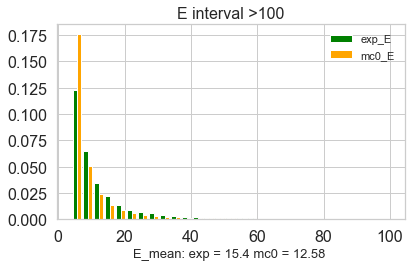

In [66]:
n = 'E(J)'
l = min( list(AllExp[n].values)+ list(AllMc0[n].values) )
r = 100
TwoGraphics_Norm(AllExp[n],AllMc0[n],l, r, 'E', 'barstacked')

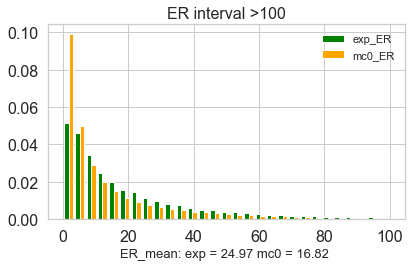

In [67]:
n = 'ER'
l = min( list(AllExp[n].values)+ list(AllMc0[n].values) )
r = 100
TwoGraphics_Norm(AllExp[n],AllMc0[n],l, r,'ER', 'barstacked')

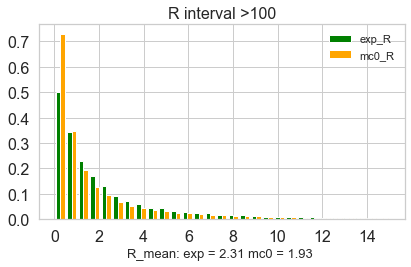

In [74]:
n = 'R'
l = min( list(AllExp[n].values)+ list(AllMc0[n].values) )
r = 15
TwoGraphics_Norm(AllExp[n],AllMc0[n],l, r, 'R', 'barstacked')

0) Координаты X и Y

2) 	Энергетические спектры (распределение по энергии частиц Eγ)  : E , sum_E

5)	Распределение по радиусам частиц по R по новому признаку E*R

In [8]:
def Choice(dataS, left, right):
    if right == None:
        d = dataS.loc[ dataS['sum_energy'] > left ].copy()
    else:
        d = dataS.loc[ (dataS['sum_energy'] >=left) & (dataS['sum_energy'] <= right)].copy() 
    return d

In [11]:
def Save_hist_1(df1, df2, L, R):
    dfE1 = Choice(df1, L, R)
    dfE2 = Choice(df2, L, R)
    
    params = ['X(J)', 'Y(J)', 'E(J)', 'R', 'lg_r', 'ER', 'lg_e_r']
    
    for n in params:
        x = list(dfE1[n].values)+ list(dfE2[n].values) 
        l = min( x )
        r = max( x )
        TwoGraphics_Norm(dfE1[n],dfE2[n],l, r, f'{n}_{L}_{R}', 'barstacked')

In [17]:
# Добавляем в общую папку гистограммы по другим распределениям
Save_hist_1(AllExp, AllMc0, 100, 200)
Save_hist_1(AllExp, AllMc0, 200, 400)
Save_hist_1(AllExp, AllMc0, 400, 700)
Save_hist_1(AllExp, AllMc0, 700, None)
Save_hist_1(AllExp, AllMc0, 100,  None)

<Figure size 432x288 with 0 Axes>

Создадим новый датафрейм с оставшимися признаками  
4)	Распределение по множественности   
6)	Распределение по средним радиусам семейств 

In [77]:
def New_dataFrame(data, name):
    
    Num_of_fam = []
    Sum_of_E = []
    plurality = []
    R_mean = []
    lg_R_mean = []
    ER_mean = []
    lg_ER_mean = []
    
    Num = set(data[name])

    
    for i in Num: 
        OneFamily = pd.DataFrame( data.loc[lambda data: data[name] == i, :] ).copy()
        s = OneFamily['E(J)'].sum()
        r = OneFamily['R'].mean()
        r_lg = np.log10(OneFamily['R']).mean()
        er = OneFamily['ER'].mean()
        er_lg = np.log10(OneFamily['ER']).mean()
        p = len(OneFamily)
        
        Num_of_fam.append(i)
        Sum_of_E.append( s )
        R_mean.append(r)
        lg_R_mean.append(r_lg)
        ER_mean.append(er)
        lg_ER_mean.append(er_lg)
        plurality.append( p )
    
    col = [name, 'sum_energy', 'mean_r', 'mean_e_r', 'lg_mean_r', 'lg_mean_er', 'n_gamma']
    
    df = pd.DataFrame({f'{name}': Num_of_fam, 
                           'sum_energy': Sum_of_E, 
                           'mean_r': R_mean,
                           'mean_e_r':ER_mean,
                           'lg_mean_r': lg_R_mean,
                           'lg_mean_er': lg_ER_mean,
                           'n_gamma': plurality,
                          }, columns = col )
    return df

In [78]:
AllExpNew = New_dataFrame(AllExp, ' num_of_fam')
AllMc0New = New_dataFrame(AllMc0, 'num')

In [80]:
AllExpNew.head()

,num_of_fam,sum_energy,mean_r,mean_e_r,lg_mean_r,lg_mean_er,n_gamma
0,1,145.800,1.025121,12.896953,-0.001034,0.971715,13
1,2,200.964,1.113121,12.534493,-0.059553,1.028002,13
2,3,642.961,1.696953,19.468334,-0.003690,1.035357,34
3,4,117.368,4.342415,29.669540,0.582342,1.396778,17
4,5,200.957,2.246727,16.972735,0.138317,1.096241,17


In [81]:
AllMc0New.head()

,num,sum_energy,mean_r,mean_e_r,lg_mean_r,lg_mean_er,n_gamma
0,1,370.199507,1.869099,16.955191,0.085734,0.949441,26
1,2,182.664647,2.279623,29.659015,0.266237,1.244146,14
2,3,450.820101,1.945030,22.188736,0.173969,1.119088,40
3,4,299.830038,1.786180,30.642564,0.134789,1.072857,11
4,5,151.722557,1.863308,15.880590,0.122099,1.029712,17


1) Распределение числа γ-семейств по ∑Eγ (при абсолютном пороге Ec = 4 ТэВ) и ∑E′γ (при относительном пороге fс=0.04)

In [84]:
def treshold(data, name):
    
    #thrdata = []
    newE = []
    newN = []
    Num = set(data[name])

    for i in Num: 
        OneFamily = pd.DataFrame( data.loc[lambda data: data[name] == i, :] ).copy()

        OneFamily['new'] = [float(0)]*len(OneFamily)
        
        s = 0.04 
        X = OneFamily['E(J)'].sort_values(ascending = False).copy()
        
        for i in range(len(X)):
            x = X[i:i+1]/(X[:i+1].sum())
            val = round(list(x)[0],3)
            if (val<0.04):
                break
            else:
                OneFamily['new'].at[x.index[0]] = val 
        
        Interest = OneFamily['E(J)'][OneFamily['new']>s]
        E = round(Interest.sum())
        N = len(Interest)
        newE.append(E)
        newN.append(N)
        #thrdata.append( OneFamily[OneFamily['new']>0.04] )
    
    return newN, newE

In [85]:
AllExpNew['n_gamma_thr'], AllExpNew['sum_energy_thr'] = treshold(AllExp, ' num_of_fam')
AllMc0New['n_gamma_thr'], AllMc0New['sum_energy_thr'] = treshold(AllMc0, 'num')

In [86]:
# Сохраняем окончательный вариант датафрейма со всеми распределениями.
# AllExpNew.to_csv('datachanged/AllExpNewL')
# AllMc0New.to_csv('datachanged/AllMc0NewLNewBank')

Сделали датафрейм с этими признаками, теперь им всем можно построить графики

In [ ]:
AllExpNew = pandas.read_csv('datachanged/AllExpNewL')
AllMc0New = pandas.read_csv('datachanged/AllMc0NewLNewBank')

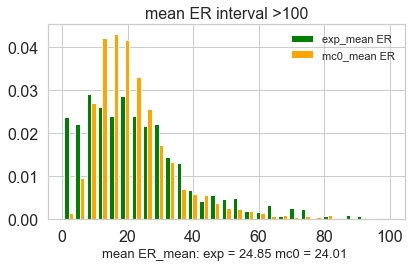

In [88]:
n = 'mean_e_r'
l = min( list(AllExpNew[n].values)+ list(AllMc0New[n].values) )
r = 100
TwoGraphics_Norm(AllExpNew[n],AllMc0New[n],l, r, 'mean ER', 'barstacked')

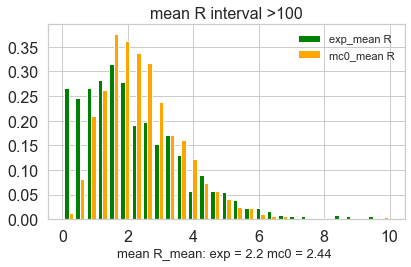

In [89]:
n = 'mean_r'
l = min( list(AllExpNew[n].values)+ list(AllMc0New[n].values) )
r = 10
TwoGraphics_Norm(AllExpNew[n],AllMc0New[n],l, r, 'mean R', 'barstacked')

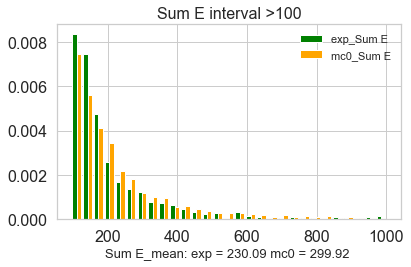

In [92]:
n = 'sum_energy_thr'
l = min( list(AllExpNew[n].values)+ list(AllMc0New[n].values) )
r = 1000
TwoGraphics_Norm(AllExpNew[n],AllMc0New[n],l, r, 'Sum E', 'barstacked')

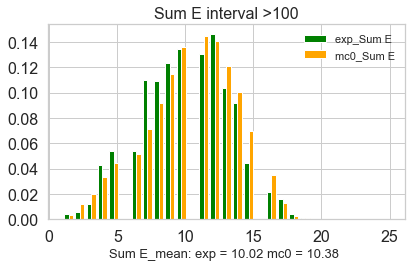

In [96]:
n = 'n_gamma_thr'
l = min( list(AllExpNew[n].values)+ list(AllMc0New[n].values) )
r = 25
TwoGraphics_Norm(AllExpNew[n],AllMc0New[n],l, r, 'Sum E', 'barstacked')

In [20]:
def Choice(dataS, left, right):
    if right == None:
        d = dataS.loc[ dataS['sum_energy'] > left ].copy()
    else:
        d = dataS.loc[ (dataS['sum_energy'] >=left) & (dataS['sum_energy'] <= right)].copy() 
    return d

In [21]:
def Save_hist_2(df1, df2, L, R):
    dfE1 = Choice(df1, L, R)
    dfE2 = Choice(df2, L, R)
    
    params = ['sum_energy', 'mean_r', 'mean_e_r', 'lg_mean_r', 'lg_mean_er', 'n_gamma', 'n_gamma_thr', 'sum_energy_thr']
    
    for n in params:
        x = list(dfE1[n].values)+ list(dfE2[n].values)
        l = min( x )
        r = max( x )
        TwoGraphics_Normalized(dfE1[n],dfE2[n],l, r, f'{n}_{L}_{R}', 'barstacked')

In [22]:
# Сохраняем графики в общую папку
Save_hist_2(AllExpNew, AllMc0New, 100, 200)
Save_hist_2(AllExpNew, AllMc0New, 200, 400)
Save_hist_2(AllExpNew, AllMc0New, 400, 700)
Save_hist_2(AllExpNew, AllMc0New, 700, None)
Save_hist_2(AllExpNew, AllMc0New, 100,  None)

<Figure size 432x288 with 0 Axes>

8. Рассмотрим новое распределение взаимных расстояний частиц семейста.  

In [102]:
# Функция вычисления матрицы расстояния для одного датафрейма, возвращает датафрейм расстояний
# Можно выбрать коэффициент домножения
def Matrix_of_Distance(X, Y, E, label = 2):
    Distance =[]
    for i in range(len(X)):
        Distance.append([])
        for j in range(len(Y)):
            
            if label == 1:
                Coef = 1
            elif label==2:
                Coef = math.sqrt(E[i]*E[j])
            elif label ==3:
                Coef=( E[i]*E[j])/(E[i] + E[j])
            
            r = Coef*(math.sqrt( math.pow((X[i]-X[j]),2) + math.pow((Y[i]-Y[j]),2) )  )
            Distance[i].append(r)
    
    return pd.DataFrame(Distance)

In [179]:
# from scipy.spatial import distance_matrix

# def Matrix_of_Distance(OneFamily, E, label = 2):
    
#     q = OneFamily[['X(J)', 'Y(J)']].values
#     distance = distance_matrix(q, q)
    
#     for i in range(len(OneFamily['X(J)'])):
#         for j in range(len(OneFamily['Y(J)'])): 
#             if label == 1:
#                 return pd.DataFrame(distance)
#             elif label==2:
#                 Coef = math.sqrt(E[i]*E[j])
#             elif label ==3:
#                 Coef=( E[i]*E[j])/(E[i] + E[j])
                
#             distance[i][j] = Coef*distance[i][j] 
    
#     return pd.DataFrame(distance)

In [181]:
def NewR(data, name, label):
    
    new = []
    Num = set(data[name])

    
    for i in Num: 
        OneFamily = pd.DataFrame( data.loc[lambda data: data[name] == i, :] ).copy()
        
        #q = (OneFamily[['X(J)', 'Y(J)']].values)        
        #df = pandas.DataFrame(distance_matrix(q, q))
        
        df = Matrix_of_Distance(OneFamily['X(J)'].values, OneFamily['Y(J)'].values, OneFamily['E(J)'].values, label)
        #df = Matrix_of_Distance(OneFamily, OneFamily['E(J)'].values, label)
        
        i, j = np.indices(df.shape)
        tmp = list(df.values[~(i <= j)] )
        
        new = new + tmp
    return new

In [183]:
%%time
ExpR = NewR(AllExp, ' num_of_fam', 2)
Mc0R = NewR(AllMc0, 'num', 2)

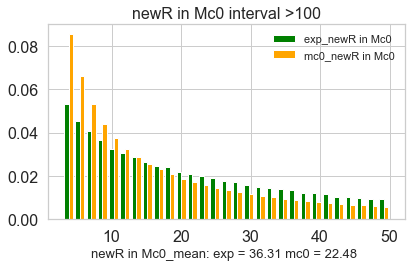

In [107]:
n = 'newR'
TwoGraphics_Norm( ExpR, Mc0R, 3, 50, 'newR',  'barstacked')

9. Реализация Критерия Колмогорова-Смирнова   
для alpha = 0.05, 1 - alpha = 0.95, y_0.95 = 1,36

Первое число - значение статистики, второе - значение С альфа, критическое значение  
Eсли статистика < С альфа выборки однородные  

In [109]:
def KS(dataS1, dataS2, Some, alpha): 
    
    n1 = len(dataS1)
    n2 = len(dataS2)
    
    ExpEcdf = ECDF(dataS1)
    Mx, My = ECDF(dataS2).x, ECDF(dataS2).y
    
    sup = max(abs(np.array(ExpEcdf(Mx)) - np.array(My)))
    
    K = np.sqrt(n1*n2/(n1+n2))*sup
    
    if alpha == 0.05:
        Calpha = 1.36
    elif alpha == 0.01:
        Calpha = 1.63
        
    Dalpha = np.sqrt((n1+n2)/(n1*n2))*Calpha
    
#     if(sup<Calpha):
#         print('Accept H0')
#     else:
#         print('Reject H0')
            
    #print(f'{Some}, statistic K = ', K)
    #print(f'{Some}, statistic D = ', sup)
    #print(f'{Some}, value C =  ', Calpha )
    
    return sup, Dalpha

In [196]:
# Первое число - значение статистики, второе - значение С альфа, критическое значение
# Если статистика < С альфа выборки однородные
print(KS(AllExp['R'], AllMc0['R'], 'R', 0.05))
print(KS(AllExp['E(J)'], AllMc0['E(J)'], 'E(J)', 0.05))

(0.1266794179536257, 0.010751875171600613)
(0.1805043542284031, 0.010751875171600613)


In [115]:
# Встроенная функция критерия Колмогорова, где считается эмпирическая функция распределение и р значение
# alpha = 0.0001
# Двусторонний
print(stats.ks_2samp(AllExp['R'],AllMc0['R']))
print(stats.kstest(AllExp['R'],AllMc0['R']))
# pvalue < 0.05 неоднородные
# Односторонний
#print(stats.kstest(AllExp['E(J)'],AllMc0['E(J)'], alternative='greater'))

KstestResult(statistic=0.1266794179536257, pvalue=2.7780917871044177e-224)
KstestResult(statistic=0.1266794179536257, pvalue=2.7780917871044177e-224)


In [143]:
# Критерий равенства средних.
print(stats.ttest_ind(AllExp['R'], AllMc0['R'], equal_var = False).pvalue)

9.511757168673798e-69


In [121]:
from scipy.stats import bartlett
# Критерий равенства дисперсий.
print(bartlett(AllExp['R'], AllMc0['R']).pvalue)

0.10143145438897996


In [120]:
from scipy.stats import levene
# Критерий равенства дисперсий отклоняется. Должен быть менее чувствителен к отклонениям от нормальности. 
print(levene(AllExp['R'], AllMc0['R']).pvalue)

2.4597532775550376e-19


In [122]:
# Гипотеза отклонёна. Выборки не похожи. 
print(stats.mannwhitneyu(AllExp['R'], AllMc0['R']).pvalue)

2.4977943989447495e-233


Эмпирическая функция распреления

In [110]:
# Ревлизация ecdf
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

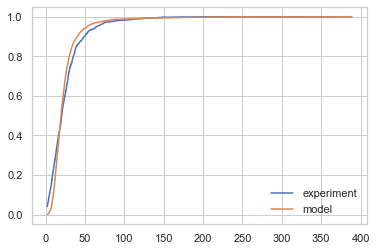

In [202]:
n = 'mean_e_r'
ExpEcdf = ECDF(AllExpNew[n])
Mx, My = ECDF(AllMc0New[n]).x, ECDF(AllMc0New[n]).y
x = Mx
y = ExpEcdf(Mx)
plt.plot(x, y, label="experiment")
plt.plot(Mx, My, label="model")
plt.legend()
plt.show()

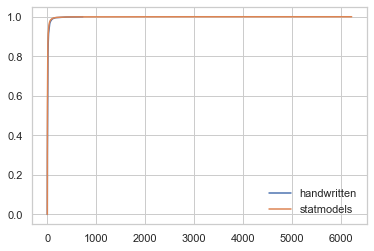

In [200]:
xs, ys = ecdf(AllExp['E(J)'])
plt.plot(xs, ys, label="handwritten")
cdf = ECDF(AllMc0['E(J)'])
plt.plot(cdf.x, cdf.y, label="statmodels")
plt.legend()
plt.show()

In [77]:
def Empirical_1(df1, df2):    
    
    params = ['X(J)', 'Y(J)', 'E(J)', 'R', 'lg_r', 'ER', 'lg_e_r']
    
    for n in params:
        dfE1 = ECDF(df1[n])
        dfE2 = ECDF(df2[n])
        tit = f'Empiric_f_{n}'
        
        plt.rcParams['font.size'] = '16'
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
            
        plt.figure(figsize=(10,5))
        plt.plot(dfE1.x, dfE1.y, label='exp')
        plt.plot(dfE2.x, dfE2.y, label='mc0')
        plt.legend(loc='lower right')
        plt.xlabel(n, size = 16)
        #plt.savefig(f'images/empirical_unif/{tit}.png', dpi=100)
        plt.clf()

In [78]:
def Empirical_2(df1, df2):
    
    params = ['sum_energy', 'mean_r', 'mean_e_r', 'lg_mean_r', 'lg_mean_er', 'n_gamma', 'n_gamma_thr', 'sum_energy_thr']
    
    for n in params:
        dfE1 = ECDF(df1[n])
        dfE2 = ECDF(df2[n])
        tit = f'Empiric_f_{n}'
        fig, ax = plt.subplots()
        
        plt.rcParams['font.size'] = '16'
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
            
        plt.plot(dfE1.x, dfE1.y, label='exp')
        plt.plot(dfE2.x, dfE2.y, label='mc0')
        plt.legend(loc='lower right')
        plt.xlabel(n, size = 16)
        #plt.show()
        #plt.savefig(f'images/empirical_unif/{tit}.png', dpi=100)
        plt.clf()

In [79]:
# Сохраняем эмпирические функции распределения в папку empirical_unif
Empirical_1(AllExp, AllMc0)
Empirical_2(AllExpNew, AllMc0New)

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

9. Подсчет среднего, дисперсии, ассиметрии, эксцесса.

In [132]:
def get_entropy(x):    
    entropy = 0     
    p = np.unique(x, return_counts = True)[1]/len(x)
    entropy = (-p*np.log10(p)).sum()    
    return entropy

In [136]:
def entropy4(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    base = e if base is None else base
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

In [137]:
from scipy.stats import entropy
x = [1, 2, 2, 3, 4]
print(entropy4(x, base = 10))

0.5785580060704263


Общая функция для сравнения однородности модели и эксперимента. В ней сохраняются все статистические оценки и значения критериев.

In [148]:
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import entropy
from scipy.stats import levene
import random
from math import log, e


# Теперь сравним распределения в модели и в эксперименте
#  Средние, дисперсии (var), ассиметрия (skew) эксцесс(kurtosis)
def Calculate_csv (dataS2, dataS1, Some, interval):
    col_new = ['Name', 'mean', 'var', 'skew', 'kurtosis', 'sampling error', 'relative error', 
               'ks D_a C_a a = 0.05', 'ks D_a C_a a = 0.01', 'ks-pvalue abs', 'ks-pvalue greater', 
               'mannwhitneyu', 't-test st p-value', 'levene st p-value', 'entropy' ]
    
    x, y = KS(dataS1, dataS2, Some, 0.05)
    x1, y1 = KS(dataS1, dataS2, Some, 0.01)
    
    st, p = stats.kstest(dataS1,dataS2, alternative='two-sided')
    
    st0, p0 = stats.kstest(dataS1,dataS2, alternative='greater')
    
    st1, p1 = stats.mannwhitneyu(dataS1, dataS2)
    
    st2, p2 = stats.ttest_ind(dataS1, dataS2, equal_var = False)
    
    st3, p3 = levene(dataS1, dataS2)
    
    
    Exp = [f'{Some} Mc0 in {interval}', 
           round(np.mean(dataS1), 3), 
           round(np.var(dataS1), 3), 
           round(skew(dataS1), 3), 
           round(kurtosis(dataS1), 3),
           round(np.abs(np.sqrt(np.var(dataS1)/len(dataS1)) ),3),
           round(np.abs((np.mean(dataS1) - np.mean(dataS2) ) /np.mean(dataS2)), 3),
           round(x, 3),
           round(x1, 3),
           '',
           '',
           '',
           '',
           '',
           round(entropy4(dataS1),3)
          ] 
    
    Mc0 = [f'{Some} Exp in {interval}', 
           round(np.mean(dataS2), 3), 
           round(np.var(dataS2), 3), 
           round(skew(dataS2), 3), 
           round(kurtosis(dataS2), 3),
           round(np.abs(np.sqrt(np.var(dataS2)/len(dataS2) )),3),
           round(np.abs((np.mean(dataS2) - np.mean(dataS1))/np.mean(dataS1)), 3),
           round(y, 3),
           round(y1, 3),
           round(p, 3),
           round(p0, 3),
           round(p1, 3),
           round(p2, 3),
           round(p3, 3),
           round(entropy4(dataS2),3)
          ]
    
    data = [Exp, Mc0]
    
    
    df = pd.DataFrame(data, columns = col_new)
    return df
    
    
def Choice(dataS, left, right):
    if right == None:
        d = dataS.loc[ dataS['sum_energy'] > left ].copy()
    else:
        d = dataS.loc[ (dataS['sum_energy'] >=left) & (dataS['sum_energy'] <= right)].copy() 
    return d

def Cal_S(dataS1, dataS2, L, R, col):
    
    if R == None:        
        interval = f'( >{L})'
    else:  
        interval = f'({L}, {R})'
        
    
    x = Choice(dataS1, L, R)
    y = Choice(dataS2, L, R)
    
    col_new = ['Name', 'mean', 'var', 'skew', 'kurtosis', 'sampling error', 'relative error', 
               'ks D_a C_a a = 0.05', 'ks D_a C_a a = 0.01', 'ks-pvalue abs', 'ks-pvalue greater', 'mannwhitneyu', 't-test st p-value', 
               'levene st p-value', 'entropy']
    df_col = pd.DataFrame(columns = col_new)
    
    data_new = []
    
    for u in col:
        df_new = Calculate_csv(x[u], y[u], u, interval)
        data_new.append(df_new)
        

    return pd.concat(data_new)

In [149]:
# Функция создания распределения взаимных расстояний
def R_datafr(L, R, name, label):
    if R == None:
        interval = f'( >{L})'
    else:      
        interval = f'({L}, {R})'
    
    E = NewR(Choice(AllExp, L, R), ' num_of_fam', label)
    M = NewR(Choice(AllMc0, L, R), 'num', label)
    
    #TwoGraphics_Norm( E, M, l , r,  n, n , f'{L}-{R}_EM',  'barstacked')
    
    dfR = Calculate_csv(E, M, f'{name}', interval)
    return dfR    

In [154]:
%%time
columns = ['X(J)', 'Y(J)', 'E(J)', 'R', 'ER', 'lg_r', 'lg_e_r']
d1 = Cal_S(AllExp, AllMc0, 100, 200, columns)
d2 = Cal_S(AllExp, AllMc0, 200, 400, columns)
d3 = Cal_S(AllExp, AllMc0, 400, 700, columns)
d4 = Cal_S(AllExp, AllMc0, 700, None, columns)
d5 = Cal_S(AllExp, AllMc0, 100, None, columns)
d6 = Cal_S(AllExp, AllMc0, 100, 700, columns)
# Сохренений статистик для разных интервалов энергий для общих значений колонок

Wall time: 3.35 s


In [151]:
%%time
name = 'd1'
dfd11 = R_datafr(100, 200, name, 1)
dfd12 = R_datafr(200, 400, name, 1)
dfd13 = R_datafr(400, 700, name, 1)
dfd14 = R_datafr(700, None, name, 1)
dfd15 = R_datafr(100, None, name, 1)
dfd16 = R_datafr(100, 700, name, 1)
# Сохранение статистик для распределений по взаимным расстояниям - евклидовое расстояние

Wall time: 7min 44s


In [152]:
%%time
name = 'd2'
dfd21 = R_datafr(100, 200, name, 2)
dfd22 = R_datafr(200, 400, name, 2)
dfd23 = R_datafr(400, 700, name, 2)
dfd24 = R_datafr(700, None, name, 2)
dfd25 = R_datafr(100, None, name, 2)
dfd26 = R_datafr(100, 700, name, 2)
# Сохранение статистик для распеделений по взаимным расстояниям - коэффициент корень из энергий

Wall time: 8min 33s


In [153]:
%%time
name = 'd3'
dfd31 = R_datafr(100, 200, name, 3)
dfd32 = R_datafr(200, 400, name, 3)
dfd33 = R_datafr(400, 700, name, 3)
dfd34 = R_datafr(700, None, name, 3)
dfd35 = R_datafr(100, None, name, 3)
dfd36 = R_datafr(100, 700, name, 3)
# Сохранение статистик для распределений по взаимным расстояниям - коэффициент отношение

Wall time: 9min 18s


In [66]:
#AllExpNew = pd.read_csv('datachanged/AllExpNewL')
#AllMc0New = pd.read_csv('datachanged/AllMc0NewL')

In [184]:
%%time
columns = ['mean_r', 'mean_e_r', 'lg_mean_r', 'lg_mean_er', 'n_gamma', 'n_gamma_thr', 'sum_energy_thr']
dd1 = Cal_S(AllExpNew, AllMc0New, 100, 200, columns)
dd2 = Cal_S(AllExpNew, AllMc0New, 200, 400, columns)
dd3 = Cal_S(AllExpNew, AllMc0New, 400, 700, columns)
dd4 = Cal_S(AllExpNew, AllMc0New, 700, None, columns)
dd5 = Cal_S(AllExpNew, AllMc0New, 100, None, columns)
dd6 = Cal_S(AllExpNew, AllMc0New, 100, 700, columns)
# Сохранение статистик по средним

Wall time: 14.3 s


In [188]:
part1 = pd.concat([dd1, d1, dfd11, dfd21, dfd31])
part2 = pd.concat([dd2, d2, dfd12, dfd22, dfd32])
part3 = pd.concat([dd3, d3, dfd13, dfd23, dfd33])
part4 = pd.concat([dd4, d4, dfd14, dfd24, dfd34])
part5 = pd.concat([dd5, d5, dfd15, dfd25, dfd35])
part6 = pd.concat([dd6, d6, dfd16, dfd26, dfd36])

Общее сравнение энтропий, не по интервалам энергий, а по всему диапазону.

In [190]:
entropy_mc0 = part5['entropy'][0].values
entropy_exp = part5['entropy'][1].values

In [191]:
ks, pks = KS(entropy_exp, entropy_mc0, 'entropy', 0.05)
ks1, pks1 = KS(entropy_exp, entropy_mc0, 'entropy', 0.01)
k, pk = stats.kstest(entropy_exp,entropy_mc0, alternative = 'two-sided')

m, pm = stats.mannwhitneyu(entropy_exp, entropy_mc0)
t, pt = stats.ttest_ind(entropy_exp, entropy_mc0, equal_var = False)
l, pl = levene(entropy_mc0,entropy_exp)

In [193]:
col = ['name', 'statistic', 'p-value']
part7 = pd.DataFrame({ 'name': ['ks D_a C_a a = 0.05', 'ks D_a C_a a = 0.01', 'ks-pvalue abs', 'mannwhitneyu', 't-test st p-value', 'levene st p-value'] , 
                          'statistic': [round(ks, 3), round(ks1, 3), round(k, 3), round(m, 3), round(t, 3), round(l, 3)], 
                           'p-value': [round(pks, 3), round(pks1, 3), round(pk, 3), round(pm, 3), round(pt, 3), round(pl, 3)]
                          }, columns = col )

In [195]:
#import XlsxWriter
writer = pd.ExcelWriter('UniformityNewBank.xlsx', engine='xlsxwriter')
part1.to_excel(writer, '100-200')
part2.to_excel(writer, '200-400')
part3.to_excel(writer, '400-700')
part4.to_excel(writer, '>700')
part5.to_excel(writer, '>100')
part6.to_excel(writer, '100-700')
part7.to_excel(writer, 'entropy')
writer.save()

In [194]:
part7

,name,statistic,p-value
0,ks D_a C_a a = 0.05,0.353,0.466
1,ks D_a C_a a = 0.01,0.353,0.559
2,ks-pvalue abs,0.412,0.112
3,mannwhitneyu,106.000,0.095
4,t-test st p-value,-1.443,0.160
5,levene st p-value,0.734,0.398


Получилось, что однородность в основном отклоняется. Файл UniformityNewBank.  
Получается, нужно изменить подход в объединении банков.  